<a href="https://colab.research.google.com/github/Arcane-jinx/Dataset/blob/main/Esperanza_de_vida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
pip install --upgrade gradio

Primeras 5 filas del dataset:
       Country  Year      Status  Life expectancy  Adult Mortality  \
0  Afghanistan  2015  Developing             65.0            263.0   
1  Afghanistan  2014  Developing             59.9            271.0   
2  Afghanistan  2013  Developing             59.9            268.0   
3  Afghanistan  2012  Developing             59.5            272.0   
4  Afghanistan  2011  Developing             59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles  ...  \
0             62     0.01              7127962362         65.0     1154  ...   
1             64     0.01              7352358168         62.0      492  ...   
2             66     0.01              7321924272         64.0      430  ...   
3             69     0.01               781842153         67.0     2787  ...   
4             71     0.01              7097108703         68.0     3013  ...   

   Polio  Total expenditure  Diphtheria  HIV/AIDS          GDP  Popu

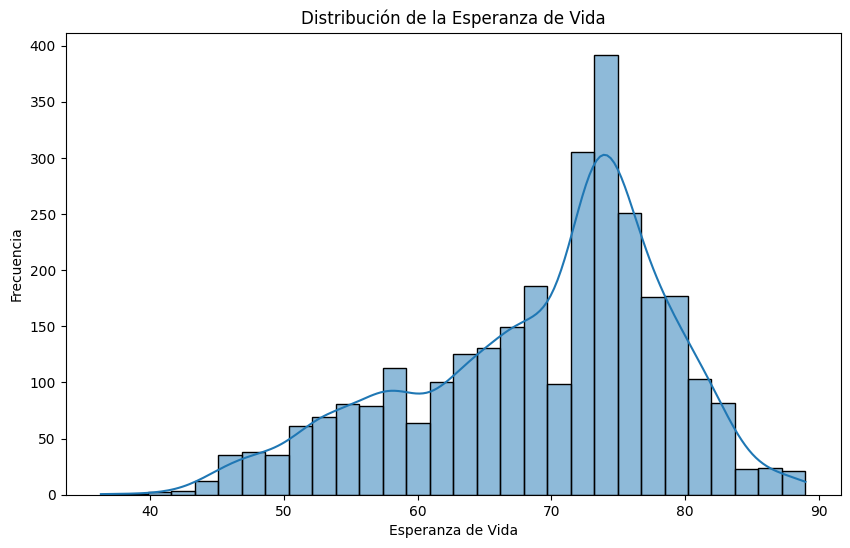

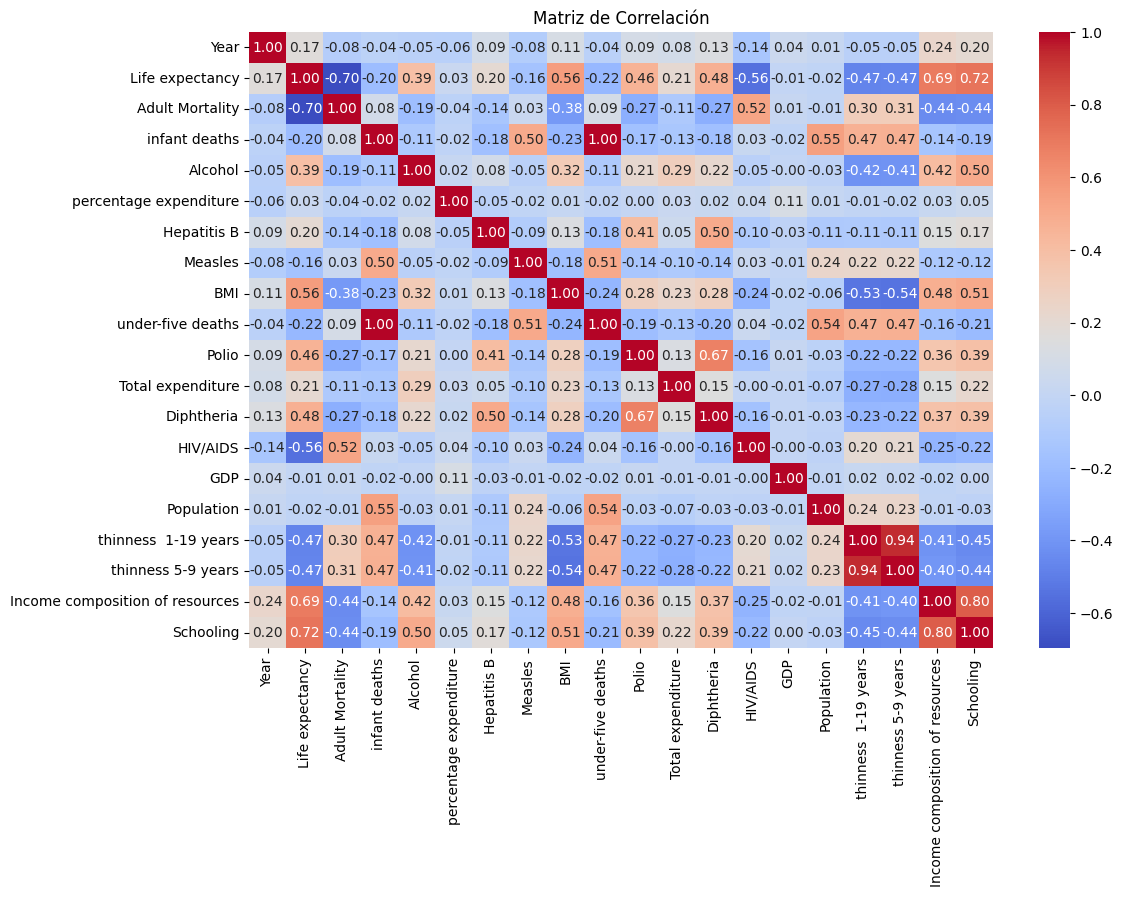


Tipos de datos en X:
Year                                 int64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure               int64
Hepatitis B                        float64
Measles                              int64
BMI                                float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
HIV/AIDS                           float64
GDP                                float64
Population                         float64
thinness  1-19 years               float64
thinness 5-9 years                 float64
Income composition of resources    float64
Schooling                          float64
Status_Developing                     bool
dtype: object

Resultados del modelo:
Error cuadrático medio (MSE): 15.59
Coeficiente de determinación (R²): 0.82


In [36]:
# Importar bibliotecas necesarias
# Proceso mental: Necesito pandas, numpy, seaborn y matplotlib para manejar y visualizar datos.
# sklearn para el modelo de regresión lineal. Ahora agrego gradio para crear una interfaz interactiva
# que haga el proyecto más atractivo y permita a los usuarios hacer preguntas fácilmente.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr

# 1. Cargar el dataset
# Proceso mental: El dataset es un CSV con delimitador ';'. Uso pd.read_csv con sep=';' para
# separar las columnas correctamente. Esto es crítico, porque un delimitador incorrecto arruinaría
# todo el análisis. Asumo que el archivo está subido a Colab, pero debo recordar al usuario
# ajustar el nombre del archivo.
df = pd.read_csv('/content/Esperanza_de_vida2000-2015.csv', sep=';')  # Ajusta al nombre real, ej: 'life_expectancy.csv'

# 2. Limpiar nombres de columnas
# Proceso mental: Los nombres de columnas pueden tener espacios extra (como 'Life expectancy '),
# lo que causa errores al acceder a ellas. Los limpio con str.strip() para que sean consistentes.
# Esto hace el código más robusto y fácil de usar más adelante.
df.columns = df.columns.str.strip()

# 3. Convertir columnas problemáticas a numérico
# Proceso mental: 'GDP' y 'percentage expenditure' son texto por los puntos en los separadores de
# miles (ej: '345.463.714'). Esto causó un error antes, así que los convierto a float eliminando
# los puntos y usando pd.to_numeric. Si hay valores no válidos, los convierto a NaN para manejarlos después.
for col in ['GDP', 'percentage expenditure']:
    df[col] = pd.to_numeric(df[col].str.replace('.', ''), errors='coerce')

# 4. Explorar el dataset
# Proceso mental: Quiero entender la estructura del dataset antes de hacer cualquier transformación.
# Imprimo las primeras filas para verificar que las columnas están bien separadas. info() me muestra
# los tipos de datos y valores nulos, shape me da el tamaño, y describe() me ofrece un resumen estadístico
# para tener una idea de los rangos de las variables.
print("Primeras 5 filas del dataset:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nDimensiones del dataset:")
print(df.shape)

print("\nEstadísticas descriptivas:")
print(df.describe())

# 5. Verificar valores nulos y duplicados
# Proceso mental: Los valores nulos y duplicados pueden afectar el modelo. Verifico cuántos nulos
# hay por columna para decidir cómo manejarlos. También busco duplicados, porque filas idénticas
# podrían sesgar los resultados. Esto me da una visión clara de la calidad de los datos.
print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())

# 6. Limpiar el dataset
# Proceso mental: Ahora limpio los datos para que estén listos para el modelo.
# - Elimino duplicados para evitar redundancias.
# - Relleno valores nulos en columnas numéricas con la media, porque es una forma simple de
#   mantener la distribución general sin introducir mucho sesgo. Podría usar la mediana si hay
#   valores atípicos, pero la media es suficiente por ahora.
# - Verifico nuevamente los nulos para confirmar que todo está resuelto.
df = df.drop_duplicates()

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

print("\nValores nulos después de la limpieza:")
print(df.isnull().sum())

# 7. Visualizaciones iniciales
# Proceso mental: Las visualizaciones me ayudan a entender los datos antes de modelar. Un histograma
# de 'Life expectancy' muestra su distribución (¿es normal? ¿sesgada?). Una matriz de correlación
# revela qué variables están más relacionadas con la esperanza de vida, lo que guiará la interpretación
# del modelo. Uso solo columnas numéricas para la correlación para evitar errores con texto.
plt.figure(figsize=(10, 6))
sns.histplot(df['Life expectancy'], bins=30, kde=True)
plt.title('Distribución de la Esperanza de Vida')
plt.xlabel('Esperanza de Vida')
plt.ylabel('Frecuencia')
plt.show()

numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# 8. Preparar datos para el modelo
# Proceso mental: Para el modelo, necesito separar las características (X) y la variable objetivo (y).
# - Elimino 'Country' porque es texto y no es útil para la regresión (es un identificador).
# - Codifico 'Status' como dummy variables (0 o 1) para que el modelo pueda usarla. drop_first=True
#   evita multicolinealidad al eliminar una categoría redundante.
# - Defino X (todas las columnas menos 'Life expectancy') y y ('Life expectancy').
# - Verifico los tipos de datos en X para asegurarme de que todo es numérico, porque el modelo
#   no puede manejar texto.
df = df.drop(['Country'], axis=1, errors='ignore')
df = pd.get_dummies(df, columns=['Status'], drop_first=True)

X = df.drop('Life expectancy', axis=1)
y = df['Life expectancy']

print("\nTipos de datos en X:")
print(X.dtypes)

# 9. Dividir los datos
# Proceso mental: Divido los datos en entrenamiento (80%) y prueba (20%) para evaluar cómo
# generaliza el modelo a datos nuevos. Uso random_state=42 para que los resultados sean
# reproducibles. Esto simula un escenario real donde el modelo predice datos no vistos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Entrenar el modelo
# Proceso mental: Elijo una regresión lineal porque es simple, interpretable y adecuada para
# predecir un valor continuo como la esperanza de vida. Durante el entrenamiento, el modelo
# aprende los coeficientes que mejor relacionan X con y.
model = LinearRegression()
model.fit(X_train, y_train)

# 11. Evaluar el modelo
# Proceso mental: Quiero saber qué tan bueno es el modelo. Calculo:
# - MSE: Promedio de los errores al cuadrado. Menor es mejor.
# - R²: Proporción de la varianza explicada. Cercano a 1 es ideal.
# También guardo los coeficientes para usarlos en la interfaz de Gradio más adelante.
mse = mean_squared_error(y_test, model.predict(X_test))
r2 = r2_score(y_test, model.predict(X_test))

print("\nResultados del modelo:")
print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")

# Guardar coeficientes para la interfaz
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values(by='Coeficiente', ascending=False)

# 12. Definir funciones para la interfaz de Gradio
# Proceso mental: Gradio necesita funciones que respondan a las entradas del usuario. Creo varias
# funciones para diferentes tipos de preguntas:
# - Una para estadísticas generales del dataset.
# - Una para mostrar los coeficientes del modelo.
# - Una para predecir la esperanza de vida con valores ingresados por el usuario.
# Esto hace que la interfaz sea versátil y atractiva.
def get_dataset_stats():
    stats = df.describe().to_string()
    return f"Estadísticas del dataset:\n{stats}"

def get_model_coefficients():
    return f"Importancia de las variables (coeficientes):\n{coef_df.to_string(index=False)}"

def predict_life_expectancy(year, adult_mortality, infant_deaths, alcohol, percentage_expenditure,
                           hepatitis_b, measles, bmi, under_five_deaths, polio, total_expenditure,
                           diphtheria, hiv_aids, gdp, population, thinness_1_19_years,
                           thinness_5_9_years, income_composition, schooling, status_developed):
    # Proceso mental: Tomo los valores ingresados por el usuario y los convierto en un array
    # que el modelo pueda usar. Aseguro que el orden coincida con X. 'Status_Developed' es 1
    # si el usuario selecciona 'Developed', y 0 si es 'Developing' (por drop_first=True).
    input_data = np.array([[
        year, adult_mortality, infant_deaths, alcohol, percentage_expenditure,
        hepatitis_b, measles, bmi, under_five_deaths, polio, total_expenditure,
        diphtheria, hiv_aids, gdp, population, thinness_1_19_years,
        thinness_5_9_years, income_composition, schooling, status_developed
    ]])
    prediction = model.predict(input_data)[0]
    return f"Esperanza de vida predicha: {prediction:.2f} años"

def answer_question(question):
    # Proceso mental: Esta función maneja preguntas abiertas. Uso palabras clave para identificar
    # qué quiere el usuario. Es una solución simple, pero puedo expandirla más tarde si necesito
    # algo más sofisticado, como integrar un modelo de lenguaje.
    question = question.lower()
    if "mortalidad" in question or "adult mortality" in question:
        coef = coef_df[coef_df['Variable'] == 'Adult Mortality']['Coeficiente'].values[0]
        return f"La mortalidad adulta tiene un coeficiente de {coef:.4f}. Un valor negativo significa que mayor mortalidad reduce la esperanza de vida."
    elif "escolarización" in question or "schooling" in question:
        coef = coef_df[coef_df['Variable'] == 'Schooling']['Coeficiente'].values[0]
        return f"La escolarización tiene un coeficiente de {coef:.4f}. Un valor positivo significa que más años de educación aumentan la esperanza de vida."
    elif "gdp" in question or "pib" in question:
        coef = coef_df[coef_df['Variable'] == 'GDP']['Coeficiente'].values[0]
        return f"El PIB tiene un coeficiente de {coef:.4f}. Su impacto depende del signo y magnitud."
    else:
        return "Lo siento, no entendí la pregunta. Intenta con algo como '¿cómo afecta la mortalidad?' o '¿qué pasa con la escolarización?'"


In [37]:
# 13. Crear la interfaz de Gradio
# Proceso mental: Quiero que la interfaz sea bonita y fácil de usar. Uso gr.Blocks para un diseño
# personalizado con pestañas. Cada pestaña tiene un propósito:
# - 'Estadísticas': Muestra información general del dataset.
# - 'Modelo': Explica el modelo y sus coeficientes.
# - 'Predicciones': Permite ingresar valores para predecir.
# - 'Preguntas': Responde preguntas abiertas.
# Uso CSS para hacerla visualmente atractiva con colores suaves y un diseño limpio.
with gr.Blocks(theme=gr.themes.Soft(), css="""
    .gradio-container {background-color: #f0f4f8;}
    h1 {color: #2c3e50; text-align: center;}
    .tab {padding: 20px; background-color: white; border-radius: 10px;}
""") as demo:
    gr.Markdown("# 🌍 Análisis de Esperanza de Vida (OMS)")
    gr.Markdown("Explora el dataset, el modelo y haz predicciones interactivas.")

    with gr.Tabs():
        with gr.TabItem("Estadísticas del Dataset"):
            gr.Markdown("### 📊 Información General")
            stats_button = gr.Button("Mostrar Estadísticas")
            stats_output = gr.Textbox(label="Estadísticas")
            stats_button.click(get_dataset_stats, outputs=stats_output)

        with gr.TabItem("Detalles del Modelo"):
            gr.Markdown("### 🤖 Sobre el Modelo")
            gr.Markdown("Este es un modelo de regresión lineal que predice la esperanza de vida basado en variables como mortalidad, escolarización, PIB, etc.")
            coef_button = gr.Button("Mostrar Coeficientes")
            coef_output = gr.Textbox(label="Coeficientes del Modelo")
            coef_button.click(get_model_coefficients, outputs=coef_output)

        with gr.TabItem("Hacer Predicciones"):
            gr.Markdown("### 🔮 Predice la Esperanza de Vida")
            gr.Markdown("Ingresa valores para las variables y obtén una predicción.")
            with gr.Row():
                with gr.Column():
                    year = gr.Slider(2000, 2015, step=1, label="Año")
                    adult_mortality = gr.Number(label="Mortalidad Adulta (por 1000)")
                    infant_deaths = gr.Number(label="Muertes Infantiles (por 1000)")
                    alcohol = gr.Number(label="Consumo de Alcohol (litros per cápita)")
                    percentage_expenditure = gr.Number(label="Porcentaje de Gasto en Salud")
                    hepatitis_b = gr.Number(label="Cobertura Hepatitis B (%)")
                    measles = gr.Number(label="Casos de Sarampión")
                    bmi = gr.Number(label="Índice de Masa Corporal (BMI)")
                    under_five_deaths = gr.Number(label="Muertes Menores de 5 años (por 1000)")
                    polio = gr.Number(label="Cobertura Polio (%)")
                with gr.Column():
                    total_expenditure = gr.Number(label="Gasto Total en Salud (%)")
                    diphtheria = gr.Number(label="Cobertura Difteria (%)")
                    hiv_aids = gr.Number(label="Prevalencia VIH/SIDA (por 1000)")
                    gdp = gr.Number(label="PIB")
                    population = gr.Number(label="Población")
                    thinness_1_19_years = gr.Number(label="Delgadez 1-19 años (%)")
                    thinness_5_9_years = gr.Number(label="Delgadez 5-9 años (%)")
                    income_composition = gr.Number(label="Composición de Ingresos (0-1)")
                    schooling = gr.Number(label="Años de Escolarización")
                    status_developed = gr.Dropdown([0, 1], label="Estado (0=Developing, 1=Developed)")
            predict_button = gr.Button("Predecir")
            predict_output = gr.Textbox(label="Predicción")
            predict_button.click(
                predict_life_expectancy,
                inputs=[
                    year, adult_mortality, infant_deaths, alcohol, percentage_expenditure,
                    hepatitis_b, measles, bmi, under_five_deaths, polio, total_expenditure,
                    diphtheria, hiv_aids, gdp, population, thinness_1_19_years,
                    thinness_5_9_years, income_composition, schooling, status_developed
                ],
                outputs=predict_output
            )

        with gr.TabItem("Hacer Preguntas"):
            gr.Markdown("### ❓ Pregunta lo que quieras")
            gr.Markdown("Escribe una pregunta sobre el dataset o el modelo, por ejemplo: '¿Cómo afecta la mortalidad adulta?'")
            question_input = gr.Textbox(label="Tu Pregunta")
            question_button = gr.Button("Enviar Pregunta")
            question_output = gr.Textbox(label="Respuesta")
            question_button.click(answer_question, inputs=question_input, outputs=question_output)

# 14. Lanzar la interfaz
# Proceso mental: Llamo a launch() para ejecutar la interfaz en Colab. En Colab, necesito
# share=True para obtener un enlace público, pero debo advertir que puede tardar unos segundos.
# Esto permite a los usuarios interactuar con el modelo de forma visual y dinámica.
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e2a78b41da9b811a97.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [38]:
# 12. Definir funciones para la interfaz de Gradio (actualizado)
def answer_question(question):
    # Proceso mental: Hago que las respuestas sean más atractivas y alineadas con las nuevas preguntas.
    # Uso las palabras clave para detectar qué pregunta está haciendo el usuario y doy respuestas
    # que suenen emocionantes y útiles, basadas en los coeficientes del modelo.
    question = question.lower()
    if "mortalidad" in question or "adult mortality" in question:
        coef = coef_df[coef_df['Variable'] == 'Adult Mortality']['Coeficiente'].values[0]
        if coef < 0:
            return f"¡Cuidado! La mortalidad adulta juega en contra en el tablero de la esperanza de vida, con un coeficiente de {coef:.4f}. Más mortalidad significa menos años para disfrutar."
        else:
            return f"¡Sorpresa! La mortalidad adulta tiene un coeficiente de {coef:.4f}, sugiriendo que no siempre derriba años como esperamos."
    elif "escolarización" in question or "schooling" in question:
        coef = coef_df[coef_df['Variable'] == 'Schooling']['Coeficiente'].values[0]
        if coef > 0:
            return f"¡La educación es mágica! Con un coeficiente de {coef:.4f}, cada año extra de escolarización podría ser la clave para vivir más tiempo."
        else:
            return f"¡Qué giro! La escolarización tiene un coeficiente de {coef:.4f}, sugiriendo que su poder no siempre alarga la vida como pensamos."
    elif "gdp" in question or "pib" in question:
        coef = coef_df[coef_df['Variable'] == 'GDP']['Coeficiente'].values[0]
        return f"El PIB mueve los hilos con un coeficiente de {coef:.4f}. ¿Riqueza = más vida? Depende de si este número es amigo o enemigo."
    elif "alcohol" in question:
        coef = coef_df[coef_df['Variable'] == 'Alcohol']['Coeficiente'].values[0]
        if coef < 0:
            return f"¡El alcohol podría ser un ladrón silencioso! Con un coeficiente de {coef:.4f}, más copas podrían robarnos días."
        else:
            return f"¡Salud! El alcohol tiene un coeficiente de {coef:.4f}, sugiriendo que no siempre es el villano de nuestra esperanza de vida."
    elif "gasto" in question or "salud" in question:
        coef = coef_df[coef_df['Variable'] == 'Total expenditure']['Coeficiente'].values[0]
        if coef > 0:
            return f"¡Un empujón al gasto en salud podría cambiar el juego! Con un coeficiente de {coef:.4f}, más inversión parece alargar vidas."
        else:
            return f"¡Interesante! El gasto en salud tiene un coeficiente de {coef:.4f}, sugiriendo que no siempre es la solución mágica."
    elif "población" in question or "densamente" in question:
        coef = coef_df[coef_df['Variable'] == 'Population']['Coeficiente'].values[0]
        if coef < 0:
            return f"¡Vivir apretados podría acortar días! Con un coeficiente de {coef:.4f}, más población tiende a presionar la esperanza de vida."
        else:
            return f"¡Sorpresa! Con un coeficiente de {coef:.4f}, la densidad poblacional no siempre aprieta como pensamos."
    elif "vacunas" in question or "vacunación" in question:
        coef = coef_df[coef_df['Variable'] == 'Polio']['Coeficiente'].values[0]  # Ejemplo con Polio
        if coef > 0:
            return f"¡Las vacunas son un escudo secreto! Con un coeficiente de {coef:.4f}, más cobertura (como Polio) alarga nuestras vidas."
        else:
            return f"¡Curioso! Con un coeficiente de {coef:.4f}, la cobertura de vacunas no siempre transforma la esperanza de vida como esperamos."
    elif "hábitos" in question or "estilo de vida" in question:
        coef_alcohol = coef_df[coef_df['Variable'] == 'Alcohol']['Coeficiente'].values[0]
        coef_bmi = coef_df[coef_df['Variable'] == 'BMI']['Coeficiente'].values[0]
        return f"¡Nuestros hábitos son un rompecabezas! El alcohol (coef: {coef_alcohol:.4f}) y el BMI (coef: {coef_bmi:.4f}) nos dicen si son amigos o enemigos de la esperanza de vida."
    else:
        return "¡Hmmm! No capté bien tu pregunta. Prueba algo como '¿es el alcohol un ladrón de años?' o '¿las vacunas son un escudo?'"
